In [1]:
print("hello world")

hello world


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms # .v2 as transforms
from torchvision.models import resnet50
from torchvision.ops import sigmoid_focal_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# I. Chargement des données

## 1. Structure des données

- Dossiers : Evaluation-Set/Validation/ & Evaluation-Set/Validation_Labels.csv, Training-Set/Training/ & Training-Set/Training_Labels.csv
- Images : Chaque image a un ID correspondant à son nom (ex: 1.png → ID 1). L'image Validation/1.png != Training/1.png
- CSV : Chaque ligne du CSV correspond à une image, avec l'ID en première colonne et les labels en colonnes suivantes.

## 2. Classe personnalisée pour le chargement des données


In [3]:
class RetinaDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les labels.
            transform (callable, optional): Transformations à appliquer sur les images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.labels_df = pd.read_csv(csv_file)
        # On suppose que l'ID est la première colonne et que les labels commencent à la 3ème colonne (ex: DR, ARMD, etc.)
        self.labels = self.labels_df.iloc[:, 2:].values.copy()  # On ignore la 2ème colonne (Disease_Risk) car elle n'est pas un label
        self.image_ids = self.labels_df.iloc[:, 0].values  # ID des images

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.image_ids[idx]}.png")
        image = Image.open(img_name).convert('RGB')  # Charge l'image en RGB
        label = self.labels[idx]
        label = torch.FloatTensor(label)  # Convertit le label en tenseur

        if self.transform:
            image = self.transform(image)

        return image, label

## 3. Définir les transformations

In [ ]:
def crop_image_tensor(img_tensor):
    """
    Crop an image tensor based on its dimensions.

    :param img_tensor: A tensor representing the image with shape (channels, width, height)
    """
    _, w, h = img_tensor.shape
    # Si l'image est en haute résolution (4288x2848)
    if h == 4288 and w == 2848:
        # Rogner à gauche de 260 pixels et à droite de 600 pixels
        return img_tensor[:, :, 260:-600]
    # Si l'image est en résolution standard (2144x1424)
    elif h == 2144 and w == 1424:
        # Rogner normalement (360 pixels de chaque côté)
        return img_tensor[:, :, 360:-360]
    elif h == 2048 and w == 1536:
        # Rogner à gauche de 260 pixels et à droite de 600 pixels
        return img_tensor[:, :, 280:-280]
    else:
        # Si la taille ne correspond à aucun cas connu, retourner l'image non rognée
        print(f"Expected size not recognized: {h}x{w}")
        return img_tensor


In [5]:
def get_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images = 0
    for _, pack in tqdm(enumerate(loader), total=len(loader)):
        images = pack[0]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    mean /= total_images
    std /= total_images
    return mean, std

In [6]:
# # Appliquer les transformations
# transform_get_mean_std = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(crop_image_tensor),
#     transforms.Resize((256, 256)),  # Redimensionne l'image après rognage
# ])

# train_dataset_get_mean_std = RetinaDataset(
#     root_dir='../../data/Training-Set/Training',
#     csv_file='../../data/Training-Set/Training_Labels.csv',
#     transform=transform_get_mean_std
# )

# train_loader_get_mean_std = torch.utils.data.DataLoader(
#     train_dataset_get_mean_std,
#     batch_size=16,
#     shuffle=True,
#     num_workers=0
# )

# mean, std = get_mean_std(train_loader_get_mean_std) # ~3 minutes
# print(f"Mean: {mean}")
# print(f"Std: {std}")

# df_mean_std = pd.DataFrame({
#     'Mean': mean.numpy(),
#     'Std': std.numpy()
# })
# df_mean_std.to_csv('../../data/mean-std/mean_std_256_256.csv', index=False)

# del train_dataset_get_mean_std, train_loader_get_mean_std, df_mean_std

In [7]:
mean, std = pd.read_csv('../../data/mean-std/mean_std_256_256.csv')['Mean'].values, pd.read_csv('../../data/mean-std/mean_std_256_256.csv')['Std'].values

# Copier les valeurs dans un tableau modifiable
mean = np.array(mean, dtype=np.float32, copy=True)  # Copie explicite
std = np.array(std, dtype=np.float32, copy=True)

# Convertir en tenseurs PyTorch
mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


In [8]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])


## 4. Augmentation des données

In [9]:
transform_augmented_Flip = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=mean, std=std)
])

In [10]:
transform_data_augment_RandomRotation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=30),  # Rotation aléatoire entre -30 et 30 degrés
    transforms.Normalize(mean=mean, std=std)
])

In [11]:
transform_data_augment_ColorJitter = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=mean, std=std)
])

## 5. Charger les jeux de données


In [12]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform
)
train_dataset_Flip = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented_Flip
)
train_dataset_RandomRotation = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_data_augment_RandomRotation
)
train_dataset_ColorJitter = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_data_augment_ColorJitter
)

train_dataset_data_augment = torch.utils.data.ConcatDataset([
    train_dataset,
    train_dataset_Flip,
    train_dataset_RandomRotation,
    train_dataset_ColorJitter
])

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform
)


In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset_data_augment,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)


# II. Entrainement de ResNet50

ResNet50 ne reçoit que du 256*256

## 1. Définir l'architecture du modèle

In [14]:
NUMBER_OF_CLASSES = 45  # 45 maladies possibles

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_CLASSES) # Remplace la dernière couche pour 45 classes
model = model.to(device) # Déplace le modèle vers le device (CPU ou GPU)

# Gèle les premières couches (optionnel)
for param in model.parameters(): # les premières couches gelées
    param.requires_grad = False
for param in model.fc.parameters(): # la dernière couche entraînable
    param.requires_grad = True

c:\Users\FlowUP\Documents\Projets\Eye-Disease-Classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\FlowUP\Documents\Projets\Eye-Disease-Classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 2. Fonction de perte et métriques

In [15]:
alpha = 0.25  # À ajuster selon la distribution de tes classes
gamma = 2.0   # Valeur standard pour focal loss
criterion = lambda outputs, labels: sigmoid_focal_loss(
    outputs, labels, alpha=alpha, gamma=gamma, reduction='mean'
)

# Initialisation
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## 3. Entrainement du modèle

### A. Paramétrage

In [16]:
# Early stopping
patience = 5  # Nombre d'epochs sans amélioration avant d'arrêter
min_delta = 0.001  # Différence minimale pour considérer une amélioration
best_val_loss = float('inf')
counter = 0

# Stockage des métriques
train_losses = []
train_accuracies = []
train_f1s = []
val_losses = []
val_accuracies = []
val_f1s = []

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'train_accuracies': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'val_losses': [],
    'val_accuracies': [],
    'val_f1s': [],
    'val_roc_aucs': [],
    }

num_epochs = 1  # Nombre maximal d'epochs

### B. Entrainement

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")
    model.train()
    running_loss = 0.0
    train_preds = []
    train_targets = []

    # Gradient accumulation
    accumulation_steps = 4
    optimizer.zero_grad()

    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps
        loss.backward()

        # Métriques
        running_loss += loss.item() * accumulation_steps
        preds = torch.sigmoid(outputs) > 0.5
        train_preds.extend(preds.cpu().detach().numpy())
        train_targets.extend(labels.cpu().detach().numpy())

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Métriques d'entraînement
    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(train_targets, train_preds)
    train_f1 = f1_score(train_targets, train_preds, average='micro')
    train_roc_auc = roc_auc_score(train_targets, train_preds, average='micro')
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train F1: {train_f1:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []
    
    with torch.no_grad(): # désactiver le calcul des gradients car non nécessaire pour calculer les métriques de validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            val_preds.extend(preds.cpu().detach().numpy())
            val_targets.extend(labels.cpu().detach().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_preds)
    val_f1 = f1_score(val_targets, val_preds, average='micro')
    val_roc_auc = roc_auc_score(val_targets, val_preds, average='micro')
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Val F1-score: {val_f1:.4f} | Val ROC-AUC: {val_roc_auc:.4f}")
    print(f"Used gpu memory: {torch.cuda.memory_allocated() / 1024**3:.2f} Go")

    
    # Early stopping
    scheduler.step(val_loss)  # Met à jour le scheduler en fonction de la perte de validation
    if epoch > 5:
        if (best_val_loss - val_loss) > min_delta:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Stockage des métriques
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['val_losses'].append(val_loss)
    training_statistics['val_accuracies'].append(val_accuracy)
    training_statistics['val_f1s'].append(val_f1)
    training_statistics['val_roc_aucs'].append(val_roc_auc)
    torch.cuda.empty_cache()
    print("="*70)


Epoch number: 0


100%|██████████| 320/320 [12:26<00:00,  2.33s/it]


Train Loss: 0.0195 | Train Accuracy: 0.1877 | Train F1: 0.0227
Val Loss: 0.0091 | Val Accuracy: 0.2094 | Val F1-score: 0.0000 | Val ROC-AUC: 0.5000
Mémoire GPU utilisée: 0.13 Go


In [18]:
torch.save(model.state_dict(), './models/ft_resnet50.pth')

In [19]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('./training_statistics/ft_resnet50_training_stats.csv', index=False)

# III. Analyse des résultats

In [21]:
# Charger les métriques sauvegardées
training_statistics_df = pd.read_csv('./training_statistics/ft_resnet50_training_stats.csv')

labels_graphs_training = ['Train Loss', 'Train Accuracy', 'Train F1-score', 'Train ROC-AUC']
labels_graphs_validation = ['Val Loss', 'Val Accuracy', 'Val F1-score', 'Val ROC-AUC']
columns_names_training = ['train_losses', 'train_accuracies', 'train_f1s', 'train_roc_aucs']
columns_names_validation = ['val_losses', 'val_accuracies', 'val_f1s', 'val_roc_aucs']

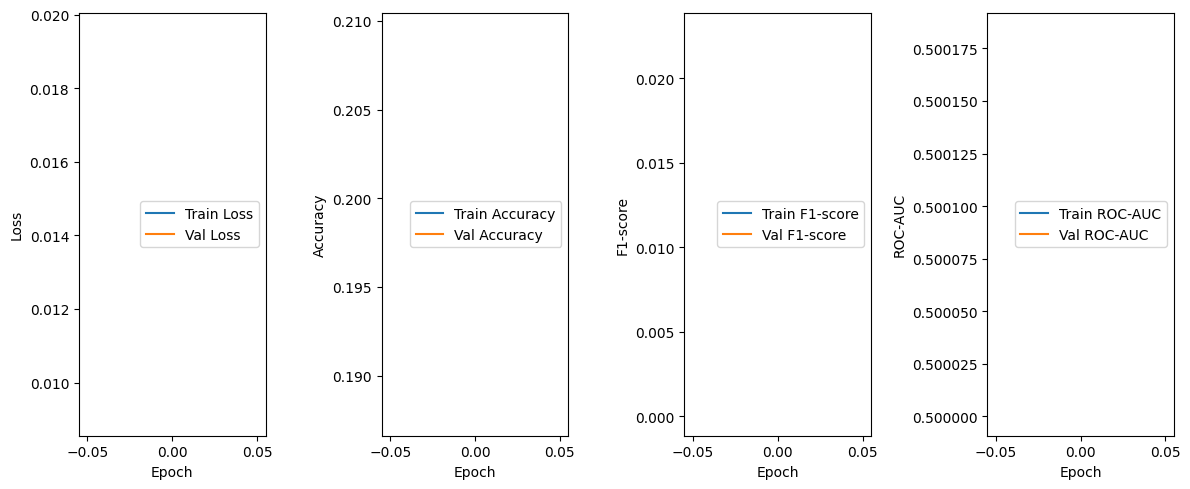

In [29]:
# Tracer les courbes
plt.figure(figsize=(12, 5))
plt.title('Training and Validation Metrics Zoomed')
plt.delaxes(plt.gca())  # Supprime l'axe vide créé par plt.title()

for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.plot(training_statistics_df[columns_names_training[i-1]], label=labels_graphs_training[i-1])
    plt.plot(training_statistics_df[columns_names_validation[i-1]], label=labels_graphs_validation[i-1])
    plt.xlabel('Epoch')
    plt.ylabel(labels_graphs_training[i-1].split()[1])  # Utilise le nom de la métrique comme label
    plt.ylim()
    plt.legend()

plt.tight_layout()
plt.savefig('training_curves_zoomed.png')
plt.show()


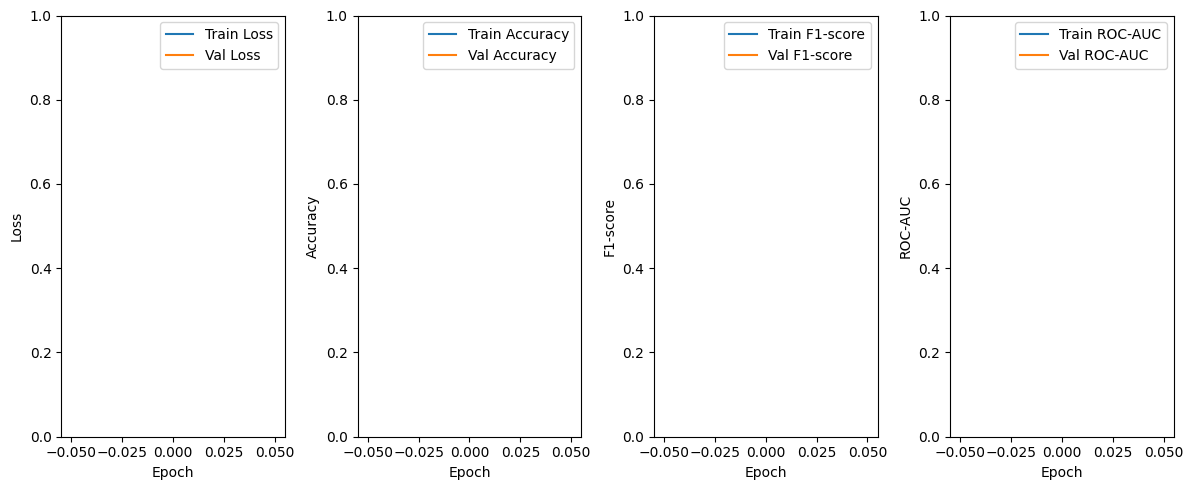

In [ ]:
# Tracer les courbes
plt.figure(figsize=(12, 5))
plt.title('Training and Validation Metrics')
plt.delaxes(plt.gca())

for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.plot(training_statistics_df[columns_names_training[i-1]], label=labels_graphs_training[i-1])
    plt.plot(training_statistics_df[columns_names_validation[i-1]], label=labels_graphs_validation[i-1])
    plt.xlabel('Epoch')
    plt.ylabel(labels_graphs_training[i-1].split()[1])  # Utilise le nom de la métrique comme label
    plt.ylim(0, 1)
    plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
